In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys_names = ['../data/expriment_2_1/O_4_4_ecp','../data/expriment_2_1/O_5_3_ecp']
sys_names = ['../data/expriment_2_1/C2H4_tau90ecp']   # ,'../data/expriment_2_1/N_5_2_ecp'
picture_name = "../picture/C2H40_ecp"
ref_filename = '../data_reference/Ga_0_level.csv'
ckpt_restore_filenames = []
for sys_name in sys_names:
    files = os.listdir(sys_name)
    for file in files:
        if 'ferminet_2023' in file and os.path.exists(sys_name+'/'+file+'/train_stats.csv'):
            ckpt_restore_filenames.append(sys_name+'/'+file+'/train_stats.csv')
    ckpt_restore_filenames.sort()

E = []
T = []
Var = []
S = []
S_numpy = []
Verli = []
for file_name in ckpt_restore_filenames[:]:
    df = pd.read_csv(file_name)
    S_index = []
    for col in df.columns:
        if "S_" in col:
            S_index.append(col)
    E.append(df['E_mean_clip'])
    T.append(df['delta_time'])
    Var.append(df['E_var_clip'])
    S.append(df[S_index])
    S_numpy.append(df[S_index].to_numpy())
    Verli.append((df['V_loc']+df['V_nloc']+df['V'])+df['T']*2)

Es = pd.DataFrame(E, index=[i for i in range(len(E))]).T
Es1 = pd.DataFrame(E, index=[i for i in range(len(E))]).T.rolling(window=100, center=True, min_periods=1).mean()
T = pd.DataFrame(T, index=[i for i in range(len(T))]).T
E_baseline = Es1.loc[Es1.index[-1]].min()
# E_baseline = -5.418821262745097
Es -= E_baseline
Es1 -= E_baseline

df = pd.read_csv(ref_filename, index_col=0)
df['Level (Hartree)'][3]
# 从字符串中提取数字
df['Level (Hartree)'] = df['Level (Hartree)'].str.extract('(\d+.\d+)', expand=False).astype(float)
baselines = df['Level (Hartree)'].values.tolist()[:40]

# baselines = [0, 0.0928,0.203,0.2079,0.2145,0.225,0.2315,0.2469,0.2469,0.2473,0.2573,0.2639,0.2669,0.2707,0.2718,0.2727,0.2773] # BeH
baselines = [0, 0.264705882, 0.272426471, 0.327205882, 0.338235294, 0.347794118, 0.355514706] # H2O
# baselines = [0, 0.232255607,0.312736585,0.312736585,0.343973494,0.363083133,0.363083133,0.37594539,0.382192771,0.396157507,0.415267146,0.418942076,0.423719486,0.424454472,0.44834152,0.452016451,0.455691381,0.455691381,0.459366312,0.459366312,0.459366312] # CO
baselines = [0, 0.2125, 0.217647059, 0.225, 0.230514706] # H2S
pd.DataFrame(T, index=[i for i in range(len(T))]).T
E_vars = pd.DataFrame(Var, index=[i for i in range(len(Var))]).T
Verlis = pd.DataFrame(Verli, index=[i for i in range(len(Verli))]).T

/tmp/ipykernel_66694/3962170560.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Level (Hartree)'][3]


/tmp/ipykernel_66694/1685552645.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Set3')


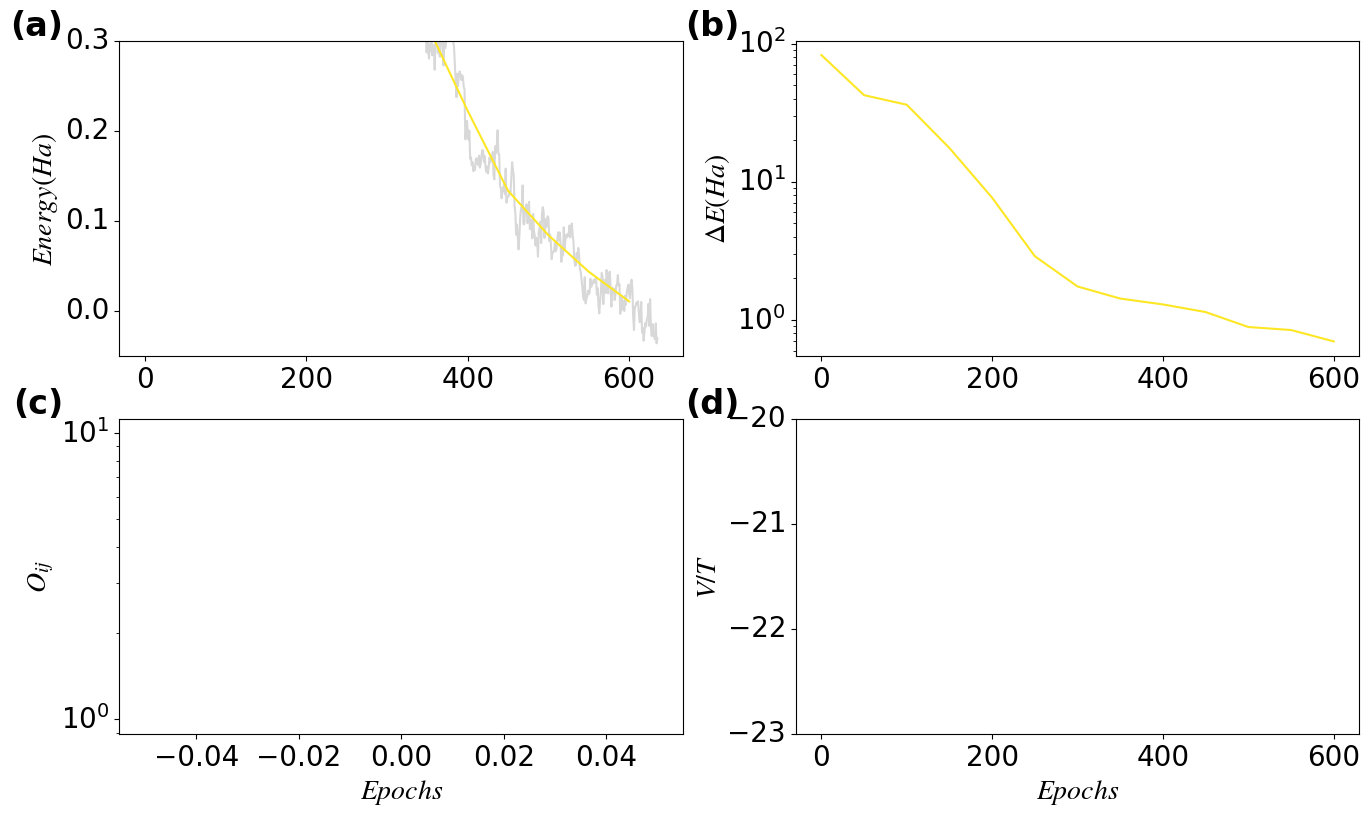

In [63]:
# 设置全局字体
# plt.rc('font',family='Times New Roman')
# 设置斜体
# plt.rcParams['font.style'] = 'italic'
# 设置公式字体
plt.rcParams['mathtext.fontset'] = 'stix'
# 设置字体大小
plt.rcParams['font.size'] = 20
# 设置背景颜色
plt.rcParams['figure.facecolor'] = 'white'
# 设置背景网格
plt.rcParams['axes.grid'] = False
# 设置ylabel对齐方式为左对齐
plt.rcParams['ytick.alignment'] = 'center'
# 设置默认颜色
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.get_cmap('viridis_r').colors[::8])

# 设置图片大小
plt.figure(figsize=(16, 9))
# 设置colormap
cmap = mpl.cm.get_cmap('Set3')

plt.subplot(221)
plt.plot(Es.loc[::1].rolling(window=1, center=True, min_periods=1).mean(), alpha=0.3, color='gray')
plt.plot(Es1.loc[::50], alpha=1)
plt.ylim(-0.05, 0.3)
plt.ylabel('$Energy (Ha)$')
# plt.xlabel('Epochs')
# plt.xscale("log")
# plt.ylim(-2.05,-1.8)
#在左上角添加(a),(b)..
plt.text(-0.1, 1.1, '({})'.format(chr(97+0)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')
# baselines=[]

# x = mc.e_tot
# baselines = x-x[0]
baselines = []
for baseline in baselines:
    # 设置灰色虚线,线宽设置为0.1
    plt.axhline(y=baseline, color='gray', linestyle='--', linewidth=0.3)


plt.subplot(222)
plt.plot(E_vars.loc[::50].rolling(window=1, center=True, min_periods=1).mean(), alpha=1)
plt.yscale("log")
# plt.xlabel('Epochs')
plt.ylabel('$\Delta E (Ha)$')
plt.text(-0.1, 1.1, '({})'.format(chr(97+1)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')
# plt.axhline(y=0.001, color='gray', linestyle='--')

plt.subplot(223)
# for s in S:
S_line = pd.concat(S, axis=1)
plt.plot(S_line.rolling(window=100, center=True, min_periods=1).mean().loc[::50], alpha=1)
plt.yscale("log")
plt.xlabel('$Epochs$')
plt.ylabel('$O_{ij}$')
plt.text(-0.1, 1.1, '({})'.format(chr(97+2)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')

plt.subplot(224)
# 按对数显示
plt.plot(Verlis.loc[::50].rolling(window=1, center=True, min_periods=1).mean(), alpha=1)
plt.xlabel('$Epochs$')
plt.ylabel('$V/T$')
# plt.xscale("log")
plt.ylim(-23,-20)
plt.text(-0.1, 1.1, '({})'.format(chr(97+3)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')
# 保存图片
plt.savefig(picture_name+'_cerve.png', dpi=600, bbox_inches='tight')
# plt.show()

C2H4_tau0ecp




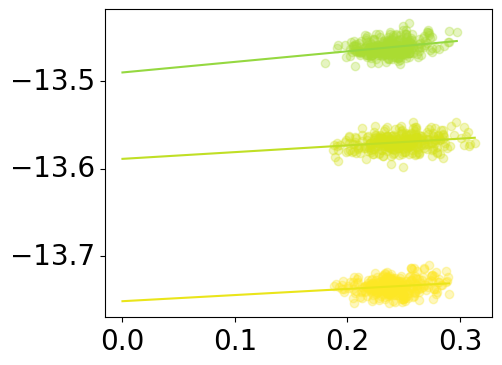

C2H4_tau15ecp




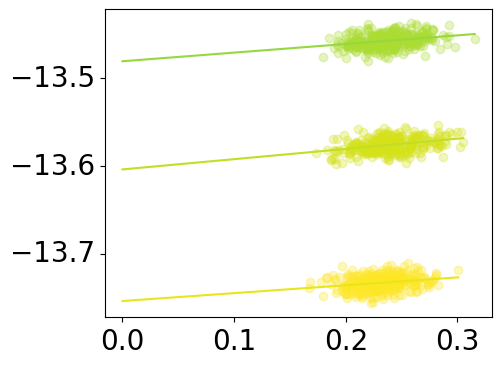

C2H4_tau30ecp




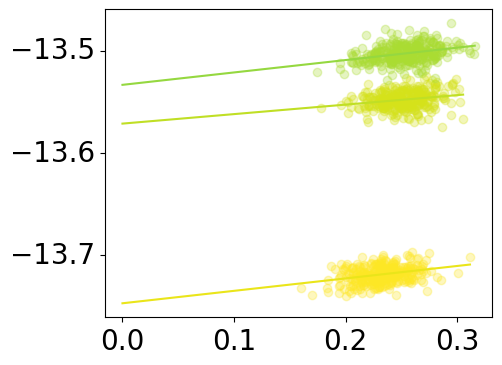

C2H4_tau45ecp




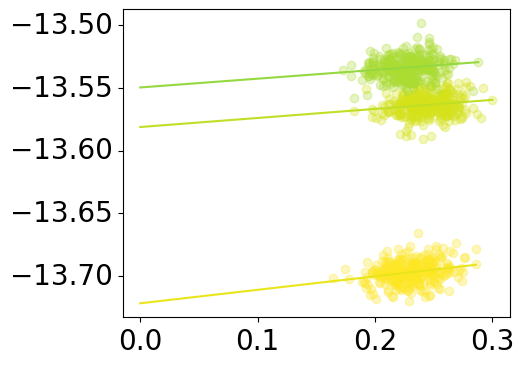

C2H4_tau60ecp




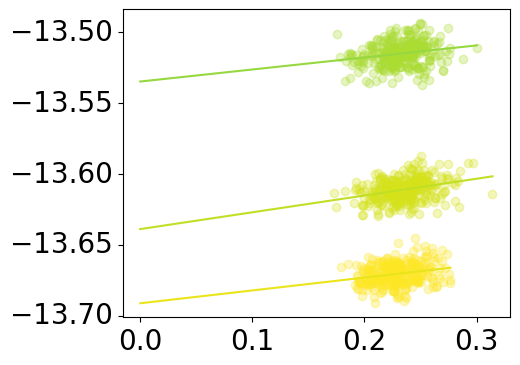

C2H4_tau70ecp




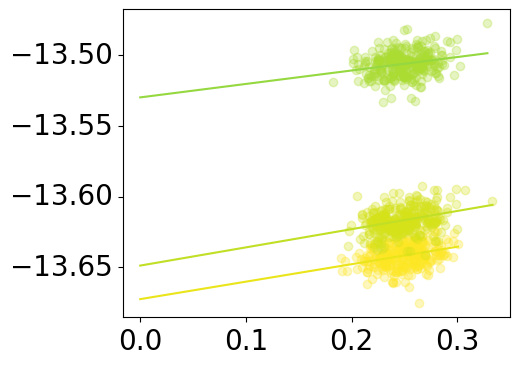

C2H4_tau80ecp




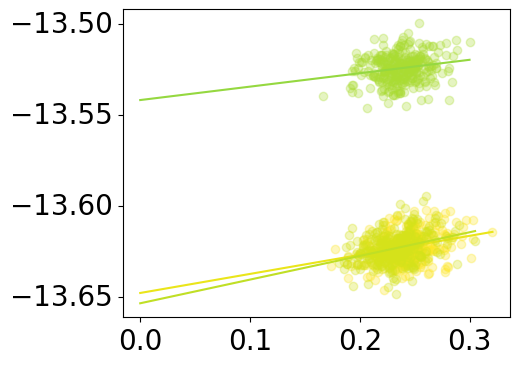

C2H4_tau85ecp




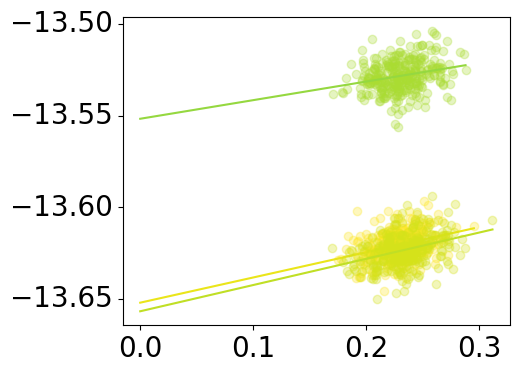

C2H4_tau90ecp


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

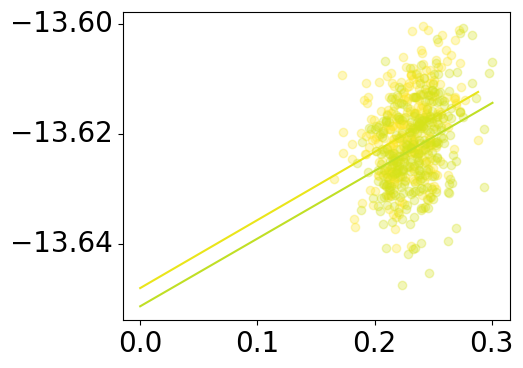

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os


sys_names = ['C2H4_tau0ecp', 'C2H4_tau15ecp', 'C2H4_tau30ecp', 'C2H4_tau45ecp', 'C2H4_tau60ecp', 'C2H4_tau70ecp', 'C2H4_tau80ecp', 'C2H4_tau85ecp', 'C2H4_tau90ecp']
result_names = ['C2H4_tau0ecp', 'C2H4_tau15ecp', 'C2H4_tau30ecp', 'C2H4_tau45ecp', 'C2H4_tau60ecp', 'C2H4_tau70ecp','C2H4_tau80ecp', 'C2H4_tau85ecp', 'C2H4_tau90ecp']

for result_name in result_names:
    if not os.path.exists(result_name):
        os.makedirs(result_name)

ckpt_restore_filenames = []
for sys_name in sys_names:
    ckpt_restore_filename = []
    files = os.listdir('../data/expriment_2_1/' + sys_name)
    for file in files:
        file_name = '../data/expriment_2_1/'+sys_name+'/'+file+'/train_stats.csv'
        if 'ferminet_2023' in file and os.path.exists(file_name):
            ckpt_restore_filename.append(file_name)
    ckpt_restore_filename.sort()
    ckpt_restore_filenames.append(ckpt_restore_filename)

E_g = {}
E_g_var = {}
E_g_std = {}
E_totals = {}
E_exciteds = {}
E_exciteds_vm = {}
E_excited_var = {}
E_excited_std = {}
E_excited_refs = {}
E_excited_terms = {}
E_excited_exp = {}
T_out = {}
E_excited_paulinets = {}
E_excited_paulinet_vars = {}
E_excited_ref_paulinets = {}
E_excited_term_paulinet = {}
E_g_pauninets = {}
E_g_pauninet_vars = {}
E_excited_pauninet_matchs = {}
E_excited_pauninet_match_vars = {}
E_totals_pauninets = {}
E_totals_pauninet_vars = {}
E_ex = {}
for sys in range(len(result_names)):
    print(result_names[sys])
    print('\n')
    E = []
    T = []
    Var = []
    S = []
    S_numpy = []
    Verli = []

    for file_name in ckpt_restore_filenames[sys]:
        df = pd.read_csv(file_name)
        S_index = []
        for col in df.columns:
            if "S_" in col:
                S_index.append(col)
        E.append(df['E_mean_clip'])
        T.append(df['delta_time'])
        Var.append(df['E_var_clip'])
        S.append(df[S_index])
        Verli.append((df['V_loc']+df['V_nloc']+df['V'])/df['T'])

    # S_matrix = np.zeros((len(S), len(S), len(S[0])))
    # for i in range(len(S)):
    #     for j in range(S[i].shape[1]):
    #         S_matrix[i][j] = S[i][S[i].columns[j]].values
    # S_matrixs = S_matrix.swapaxes(0,1) + S_matrix+np.tile(np.eye(len(S))[..., None], len(S[0]))
    # 输出数据
    # 能量收敛原始数据
    Es = pd.DataFrame(E, index=[i for i in range(len(E))]).T
    Es.to_csv(result_names[sys]+'/E.csv', header=None, index=True)
    # 不确定度原始数据
    E_vars = pd.DataFrame(Var, index=[i for i in range(len(Var))]).T
    E_vars.to_csv(result_names[sys]+'/E_var.csv', header=None, index=True)
    # 重叠系数原始数据
    S = pd.concat(S, axis=1)
    S = pd.DataFrame(S, index=[i for i in range(S.shape[1])]).T
    S.to_csv(result_names[sys]+'/S.csv', header=None, index=True)
    # 位力定理原始数据
    Verlis = pd.DataFrame(Verli, index=[i for i in range(len(Verli))]).T
    Verlis.to_csv(result_names[sys]+'/Verli.csv', header=None, index=True)
    # 时间统计原始数据
    T = pd.DataFrame(T, index=[i for i in range(len(T))]).T
    T.to_csv(result_names[sys]+'/T.csv', header=None, index=True)
    # 能量重采样数据
    Es1 = Es.rolling(window=100, center=True, min_periods=1).mean()
    E_totals[result_names[sys]] = Es1.loc[Es1.index[-50]]
    E_baseline = Es1.loc[Es1.index[-50]].min()
    # Es1 -= E_baseline
    Es1[50::100].to_csv(result_names[sys]+'/E1.csv', header=None, index=True)
    E_std = Es.rolling(window=100, center=True, min_periods=1).std()
    E_std[50::100].to_csv(result_names[sys]+'/E_std.csv', header=None, index=True)
    # 能量不确定度重采样数据
    E_vars1 = E_vars.rolling(window=100, center=True, min_periods=1).mean()
    E_vars1[50::100].to_csv(result_names[sys]+'/E_var1.csv', header=None, index=True)
    # 重叠系数重采样数据
    S1 = S.rolling(window=100, center=True, min_periods=1).mean()
    S1[50::100].to_csv(result_names[sys]+'/S1.csv', header=None, index=True)
    # 重叠矩阵数据
    # S_matrix = S_matrixs[:,:,-100:].mean(axis=2)
    # pd.DataFrame(S_matrix).to_csv(result_names[sys]+'/S_matrix.csv', header=None, index=False)
    # 设置图片大小
    # plt.figure(figsize=(5, 4))
    # cmap = mpl.cm.get_cmap('YlGn')
    # plt.imshow(S_matrix, norm=mpl.colors.LogNorm(vmin=S_matrix.min(), vmax=S_matrix.max()), cmap=cmap, alpha=1)
    # plt.colorbar()
    # 保存图片
    # plt.subplots_adjust(wspace=0.3, hspace=0)
    # plt.savefig(result_names[sys]+'/overlap.svg', dpi=600, bbox_inches='tight')
    # 位力定理重采样数据
    Verlis1 = Verlis.rolling(window=100, center=True, min_periods=1).mean()
    Verlis1[50::100].to_csv(result_names[sys]+'/Verli1.csv', header=None, index=True)
    # 耗时统计
    T1 = T.mean()
    E_excited = Es1.loc[Es1.index[-50]]
    E_excited_vm = pd.DataFrame([Es1[i][3950]-Es1[0][np.abs((E_vars1[i][3950]-E_vars1[0]).to_numpy()).argmin()] for i in Es1.columns])
    # dist = ((np.array(E_excited_vm[0])-np.array(baselines).reshape(-1,1))**2)

    E_g[result_names[sys]] = E_baseline
    E_g_var[result_names[sys]] = E_vars1[Es1.loc[Es1.index[-50]].argmin()][Es1.index[-50]]
    E_g_std[result_names[sys]] = E_std[Es1.loc[Es1.index[-50]].argmin()][Es1.index[-50]]

    E_exciteds[result_names[sys]] = Es1.loc[Es1.index[-50]]
    E_exciteds_vm[result_names[sys]] = E_excited_vm[0]
    E_excited_var[result_names[sys]] = E_vars1.loc[Es1.index[-50]]
    E_excited_std[result_names[sys]] = E_std.loc[Es1.index[-50]]
    T_out[result_names[sys]] = T.mean()

    E_out = []
    plt.figure(figsize=(5, 4))
    for ei in range(len(E_vars.columns)):
        x = E_vars[E_vars.columns[ei]].rolling(window=1, center=True, min_periods=1).mean().loc[3700:].values
        y = Es[Es.columns[ei]].rolling(window=1, center=True, min_periods=1).mean().loc[3700:].values
        p = np.polyfit(x,y,1)
        x1 = np.linspace(0, x.max(),10)
        y_fit = np.polyval(p,x1)
        plt.plot(x, y, 'o', alpha=0.3)
        plt.plot(x1,y_fit)
        E_out.append(p[1])
    plt.show()
    E_ex[result_names[sys]] = pd.DataFrame(E_out)[0]

E_base = {"E":E_g, "E_var":E_g_var, "E_std":E_g_std}
pd.DataFrame(E_base).to_csv('E_base.csv', header=True, index=True)

{'C2H4_tau0ecp': 0   -13.787463
 1   -13.630309
 2   -13.565656
 Name: 0, dtype: float64,
 'C2H4_tau15ecp': 0   -13.783233
 1   -13.628722
 2   -13.521491
 Name: 0, dtype: float64,
 'C2H4_tau30ecp': 0   -13.770666
 1   -13.607039
 2   -13.555684
 Name: 0, dtype: float64,
 'C2H4_tau45ecp': 0   -13.745634
 1   -13.616073
 2   -13.579853
 Name: 0, dtype: float64,
 'C2H4_tau60ecp': 0   -13.725083
 1   -13.697996
 2   -13.572147
 Name: 0, dtype: float64,
 'C2H4_tau70ecp': 0   -13.701854
 1   -13.678316
 2   -13.559070
 Name: 0, dtype: float64,
 'C2H4_tau80ecp': 0   -13.673146
 1   -13.668267
 2   -13.580362
 Name: 0, dtype: float64}

In [75]:
np.array([11245.98141,12406.76247,19240.03963,29259.98931,40024.59099])/219474.63

array([0.05124046, 0.05652937, 0.08766407, 0.13331832, 0.18236546])

In [76]:
np.array([0.0,35.4,38.6,56.4,84,197.1,230.9])*0.0015936010974213599

array([0.        , 0.05641348, 0.061513  , 0.0898791 , 0.13386249,
       0.31409878, 0.36796249])

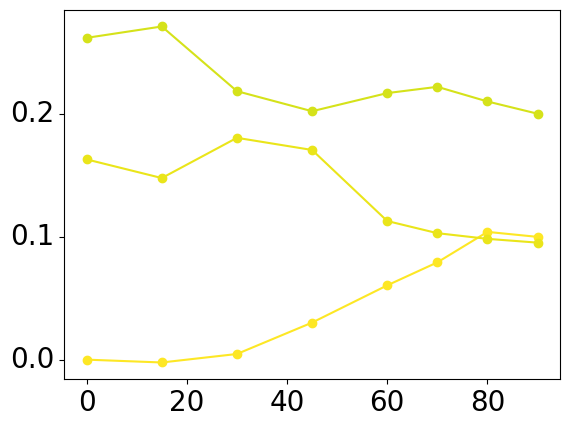

In [74]:
EPS = pd.DataFrame(E_ex).T.to_numpy()
plt.plot([0,15,30,45,60,70,80,90],EPS-EPS[0,0], 'o-')

In [57]:
pd.DataFrame(E_exciteds_vm).T.to_numpy() 

array([[ 0.        ,  0.1636607 ,  0.2722001 ],
       [ 0.        ,  0.15578306,  0.27526808],
       [ 0.        ,  0.16520745,  0.2100667 ],
       [ 0.        ,  0.12952139,  0.16184684],
       [ 0.        ,  0.05977045,  0.15641358],
       [ 0.        ,  0.02497519,  0.1340449 ],
       [ 0.        , -0.00356913,  0.09725242],
       [ 0.        , -0.00670572,  0.09112642]])

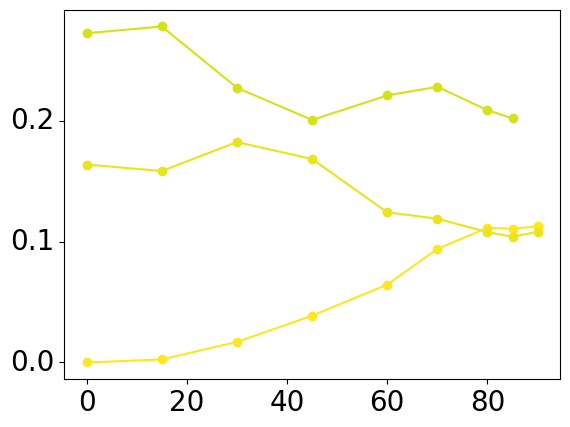

In [73]:
EPS = pd.DataFrame(E_exciteds_vm).T.to_numpy() + np.array(list(E_g.values())).reshape(-1,1)# +pd.DataFrame(E_totals).T.to_numpy()
plt.plot([0,15,30,45,60,70,80,85,90],EPS-EPS[0,0], 'o-')

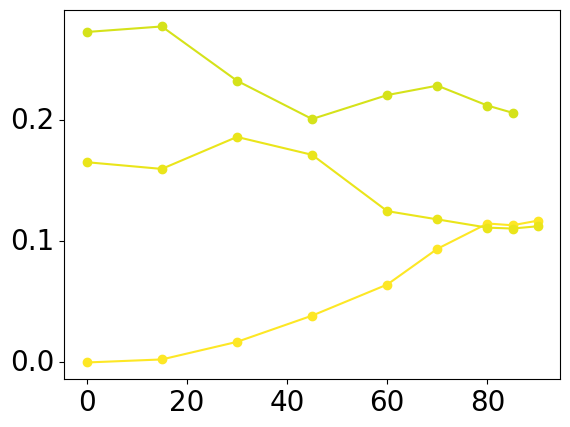

In [72]:
EPS = pd.DataFrame(E_exciteds).T.to_numpy()
plt.plot([0,15,30,45,60,70,80,85,90],EPS-EPS[0,0], 'o-')

In [178]:
EPS[0,0]

-13.75250473

In [180]:
Es1.loc[1500]-EPS[0,0]

0    0.123520
1    0.128734
2    0.222770
Name: 1500, dtype: float64

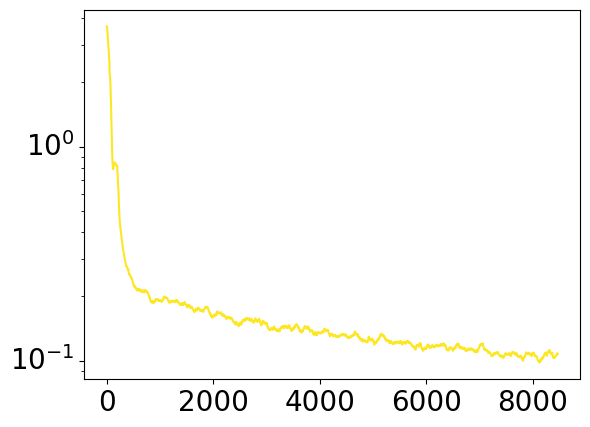

In [167]:
df = pd.read_csv("/home/gengzi/deepwavefunction/ferminet-excited/data/expriment_2_1/C2H4_10000/C2H4_0.2617993877991494ecp/ferminet_2023_12_11_15:56:10/train_stats.csv")
plt.plot(df["E_var_clip"].T.rolling(window=100, center=True, min_periods=1).mean())
plt.yscale("log")

# CASCI

In [537]:
import pyscf
mol = pyscf.M(atom='''
     C 0.00000000 0.00000000 0.60851638
     Si 0.00000000 0.00000000 -1.10883755
     H 0.00000000 0.90452009 -1.70868401
     H 0.00000000 -0.90452009 -1.70868401''',
     basis={'Si': 'ccecpccpvqz', 'C': 'ccecpccpvqz', 'H': 'ccecpccpvqz'},
     ecp={'Si': 'ccecp', 'C': 'ccecp', 'H': 'ccecp'},
     spin = 0,
     verbose=4)


mc = mol.CASCI(6, 4).DDCOSMO()
mc.fcisolver.nstates = 15
mc.with_solvent.state_id = 1  # Slow solvent wrt the first excited state
mc.run()

0
System: uname_result(system='Linux', node='localhost.localdomain', release='4.18.0-477.27.1.el8_8.x86_64', version='#1 SMP Wed Sep 20 15:55:39 UTC 2023', machine='x86_64')  Threads 52
Python 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
numpy 1.26.1  scipy 1.11.3
Date: Sat Dec  9 17:17:19 2023
PySCF version 2.4.0
PySCF path  /home/gengzi/.conda/envs/ferminet/lib/python3.11/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 C      0.000000000000   0.000000000000   0.608516380000 AA    0.000000000000   0.000000000000   1.149929300512 Bohr   0.0
[INPUT]  2 Si     0.000000000000   0.000000000000  -1.108837550000 AA    0.000000000000   0.000000000000  

In [ ]:
x = np.array([-10.0457320190388,
-10.0292464831916,
-10.0001470852957,
-9.99780403864969,
-9.94928861426228,
-9.93973202058477,
-9.91937568985149,])
x-x[0]

array([0.        , 0.01648554, 0.04558493, 0.04792798, 0.0964434 ,
       0.106     , 0.12635633])

In [529]:
Es1.iloc[18000]

0   -0.000188
1    0.000614
2    0.016504
3    0.038833
4    0.068255
5    0.071251
6    0.100459
7    0.115343
8         NaN
Name: 18000, dtype: float64

In [ ]:
x = np.array([-10.0431459914901,
-10.0167158582392,
-9.98820309081255,
-9.97998074824583,
-9.93464772457138,
-9.90921062176129,
-9.88187300254073])

In [ ]:
x-x[0]

array([0.        , 0.02643013, 0.0549429 , 0.06316524, 0.10849827,
       0.13393537, 0.16127299])

ccecpccpvqz-tddft

In [ ]:
x = np.array([1.0247779,1.482287,4.21437732,4.99969001,6.16231282,6.65354555,7.41039766,7.58160898,7.96348519,8.32962515])

In [ ]:
(x-x[0])/27.2114

array([0.        , 0.01681314, 0.11721556, 0.14607525, 0.18880083,
       0.20685329, 0.23466708, 0.24095898, 0.25499266, 0.26844805])

In [ ]:
x = np.array([0.96002094, 1.36591595, 4.17288107, 5.00116486, 6.18559069, 6.59311434, 7.09470865, 7.37004394, 7.46957225, 7.62178216])

In [ ]:
(x-x[0])/27.2114

array([0.        , 0.01491636, 0.11807037, 0.14850922, 0.19203605,
       0.20701226, 0.2254455 , 0.23556388, 0.23922148, 0.24481509])

In [ ]:
from pyscf import gto, scf, adc
mol = pyscf.M(atom='''
     C 0.00000000 0.00000000 0.60851638
     Si 0.00000000 0.00000000 -1.10883755
     H 0.00000000 0.90452009 -1.70868401
     H 0.00000000 -0.90452009 -1.70868401''',
     basis={'Si': 'ccecpccpvqz', 'C': 'ccecpccpvqz', 'H': 'ccecpccpvqz'},
     ecp={'Si': 'ccecp', 'C': 'ccecp', 'H': 'ccecp'},
     spin = 0,
     verbose=4)
mf = scf.UHF(mol).run()

myadc = adc.ADC(mf)  # This is a UADC calculation
myadc.kernel_gs()
eip,vip,pip,xip,ip_es = myadc.ip_adc()
eea,vea,pea,xea,ea_es = myadc.ea_adc()
myadc.compute_properties = False
myadc.method = "adc(3)"
myadc.method_type = "ip"
myadc.kernel(nroots = 7)

0
System: uname_result(system='Linux', node='localhost.localdomain', release='4.18.0-477.27.1.el8_8.x86_64', version='#1 SMP Wed Sep 20 15:55:39 UTC 2023', machine='x86_64')  Threads 52
Python 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
numpy 1.26.1  scipy 1.11.3
Date: Fri Dec  8 16:14:05 2023
PySCF version 2.4.0
PySCF path  /home/gengzi/.conda/envs/ferminet/lib/python3.11/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 C      0.000000000000   0.000000000000   0.608516380000 AA    0.000000000000   0.000000000000   1.149929300512 Bohr   0.0
[INPUT]  2 Si     0.000000000000   0.000000000000  -1.108837550000 AA    0.000000000000   0.000000000000  

(array([0.32890899, 0.32890899, 0.34315787, 0.34315787, 0.36096063,
        0.36096065, 0.43183108]),
 array([[ 8.02416163e-19,  4.27162913e-15,  3.27058533e-17, ...,
         -1.14047539e-10,  1.10363701e-02,  4.76092701e-18],
        [ 1.39393928e-18,  1.35864588e-14,  2.64137259e-16, ...,
         -2.29012916e-10,  2.21615600e-02,  1.73874852e-17],
        [-4.21973138e-17,  8.44489894e-03, -2.72567137e-15, ...,
         -1.28257964e-18,  7.98000953e-15, -1.28219551e-16],
        ...,
        [ 2.86277613e-18,  7.56312372e-18, -1.68906631e-13, ...,
          1.98382947e-18,  5.81875809e-21,  1.10324992e-18],
        [-3.64399509e-18,  1.53049179e-24, -2.12547166e-25, ...,
         -6.95447666e-18, -6.24590448e-26, -6.60078657e-16],
        [ 3.50105364e-18,  9.53218984e-18,  9.16265981e-14, ...,
          1.10160473e-17, -9.26658653e-20,  1.03107968e-17]]),
 None,
 (None,))

In [ ]:
np.array([0.33152636, 0.33152656, 0.33962513, 0.33962769, 0.35783641,
        0.35783989, 0.4353885 ])-0.33152636

array([0.0000000e+00, 2.0000000e-07, 8.0987700e-03, 8.1013300e-03,
       2.6310050e-02, 2.6313530e-02, 1.0386214e-01])

In [ ]:
np.array([0.32890899, 0.32890899, 0.34315787, 0.34315787, 0.36096063,
        0.36096065, 0.43183108])-0.32890899

array([0.        , 0.        , 0.01424888, 0.01424888, 0.03205164,
       0.03205166, 0.10292209])

In [ ]:
3.63/27.2

0.13345588235294117

In [ ]:
Es1.iloc[19900]

0   -0.000177
1    0.001036
2    0.016355
3    0.038748
4    0.068229
5    0.071369
6         NaN
Name: 19900, dtype: float64

In [ ]:
a=np.array([-327.534558080928, -327.505880515890, -327.502178641659, -327.474103344004, -327.449370969121])+327.534558080928

In [ ]:
a=np.array([-10.0457320190350, -10.0292464831915, -10.0001470852955, -9.99780403864956, -9.94928861426216])

In [ ]:
(a-a[0])

array([0.        , 0.01648554, 0.04558493, 0.04792798, 0.0964434 ])

<Axes: >

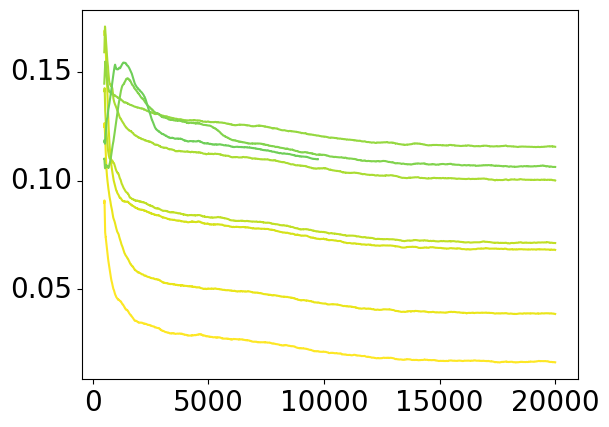

In [549]:
(E[2]-E[0]).rolling(500).mean().plot()
(E[3]-E[0]).rolling(500).mean().plot()
(E[4]-E[0]).rolling(500).mean().plot()
(E[5]-E[0]).rolling(500).mean().plot()
(E[6]-E[0]).rolling(500).mean().plot()
(E[7]-E[0]).rolling(500).mean().plot()
(E[8]-E[0]).rolling(500).mean().plot()
(E[9]-E[0]).rolling(500).mean().plot()

In [ ]:
pd.DataFrame(E, index=[i for i in range(len(E))]).T.rolling(window=100, center=True, min_periods=1).mean()

,0,1,2,3,4,5,6
0,-10.368077,-10.145341,-10.166286,-10.200374,-10.240263,-10.149965,-10.316460
1,-10.367476,-10.146793,-10.168183,-10.199174,-10.237999,-10.150274,-10.313172
2,-10.368374,-10.147626,-10.169979,-10.197968,-10.235619,-10.150804,-10.310261
3,-10.367792,-10.148755,-10.171579,-10.197325,-10.232811,-10.151058,-10.307229
4,-10.368385,-10.150132,-10.173566,-10.196716,-10.229636,-10.151380,-10.304284
...,...,...,...,...,...,...,...
19995,-10.348607,-10.346753,-10.332289,-10.310250,-10.280942,-10.277327,NaN
19996,-10.348650,-10.346739,-10.332251,-10.310240,-10.280998,-10.277347,NaN
19997,-10.348709,-10.346699,-10.332204,-10.310243,-10.280996,-10.277370,NaN
19998,-10.348703,-10.346722,-10.332189,-10.310233,-10.281027,-10.277408,NaN


/tmp/ipykernel_2030389/3458054698.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Set3')


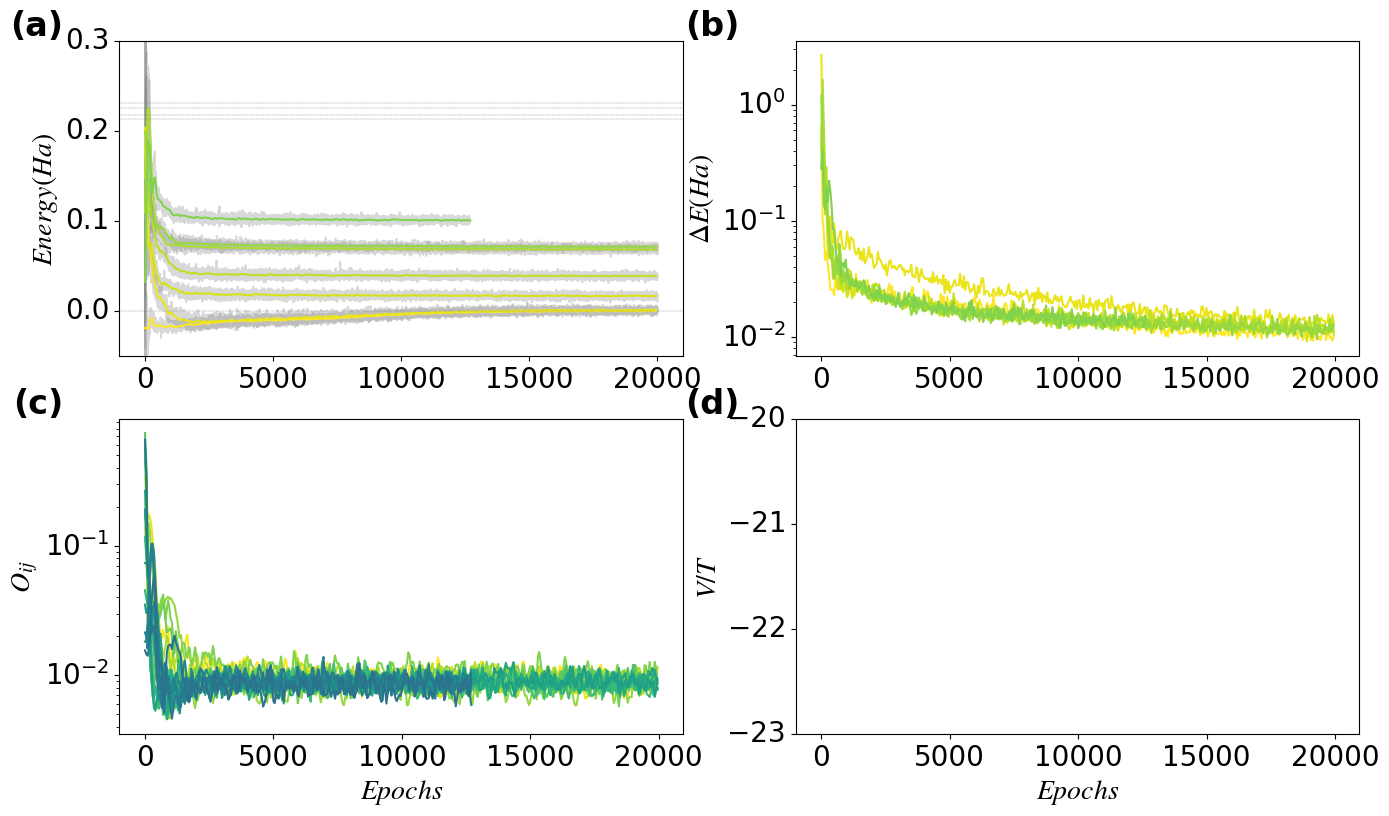

In [ ]:
# 设置全局字体
# plt.rc('font',family='Times New Roman')
# 设置斜体
# plt.rcParams['font.style'] = 'italic'
# 设置公式字体
plt.rcParams['mathtext.fontset'] = 'stix'
# 设置字体大小
plt.rcParams['font.size'] = 20
# 设置背景颜色
plt.rcParams['figure.facecolor'] = 'white'
# 设置背景网格
plt.rcParams['axes.grid'] = False
# 设置ylabel对齐方式为左对齐
plt.rcParams['ytick.alignment'] = 'center'
# 设置默认颜色
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.get_cmap('viridis_r').colors[::8])

# 设置图片大小
plt.figure(figsize=(16, 9))
# 设置colormap
cmap = mpl.cm.get_cmap('Set3')

plt.subplot(221)
plt.plot(Es.loc[::1].rolling(window=1, center=True, min_periods=1).mean(), alpha=0.3, color='gray')
plt.plot(Es1.loc[::50], alpha=1)
plt.ylim(-0.05, 0.3)
plt.ylabel('$Energy (Ha)$')
# plt.xlabel('Epochs')
# plt.xscale("log")
# plt.ylim(-2.05,-1.8)
#在左上角添加(a),(b)..
plt.text(-0.1, 1.1, '({})'.format(chr(97+0)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')
# baselines=[]
for baseline in baselines:
    # 设置灰色虚线,线宽设置为0.1
    plt.axhline(y=baseline, color='gray', linestyle='--', linewidth=0.3)


plt.subplot(222)
plt.plot(E_vars.loc[::50].rolling(window=1, center=True, min_periods=1).mean(), alpha=1)
plt.yscale("log")
# plt.xlabel('Epochs')
plt.ylabel('$\Delta E (Ha)$')
plt.text(-0.1, 1.1, '({})'.format(chr(97+1)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')
# plt.axhline(y=0.001, color='gray', linestyle='--')

plt.subplot(223)
# for s in S:
S_line = pd.concat(S, axis=1)
plt.plot(S_line.rolling(window=100, center=True, min_periods=1).mean().loc[::50], alpha=1)
plt.yscale("log")
plt.xlabel('$Epochs$')
plt.ylabel('$O_{ij}$')
plt.text(-0.1, 1.1, '({})'.format(chr(97+2)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')

plt.subplot(224)
# 按对数显示
plt.plot(Verlis.loc[::50].rolling(window=1, center=True, min_periods=1).mean(), alpha=1)
plt.xlabel('$Epochs$')
plt.ylabel('$V/T$')
# plt.xscale("log")
plt.ylim(-23,-20)
plt.text(-0.1, 1.1, '({})'.format(chr(97+3)), transform=plt.gca().transAxes,
        fontsize='large', fontweight='bold', va='top', ha='right')
# 保存图片
plt.savefig(picture_name+'_cerve.png', dpi=600, bbox_inches='tight')
# plt.show()

In [ ]:
from pyscf import gto, lib

In [ ]:
lib.param.BOHR*np.array([[0, 0, -0.50365086],[0,  1.81828105, 1.25212288],[0, -1.81828105, 1.25212288]])
lib.param.BOHR*np.array([[0, 0, 2.38483140],[0,  0, -0.02489783]])

array([[ 0.        ,  0.        ,  1.26199843],
       [ 0.        ,  0.        , -0.01317536]])

In [ ]:
lib.param.BOHR*np.array([[0, 0, 1.14992930],[0,0, -2.09539928],[0,  1.70929524, -3.22894481],[0, -1.70929524, -3.22894481]])

array([[ 0.        ,  0.        ,  0.60851638],
       [ 0.        ,  0.        , -1.10883755],
       [ 0.        ,  0.90452009, -1.70868401],
       [ 0.        , -0.90452009, -1.70868401]])

In [ ]:
lib.param.BOHR*np.array([[0, 0, 0.11427641],[0, 1.91899987, -1.75604411],[0, -1.91899987, 1.75604411]])

array([[ 0.        ,  0.        ,  0.06047247],
       [ 0.        ,  1.015491  , -0.92925852],
       [ 0.        , -1.015491  ,  0.92925852]])

In [ ]:
lib.param.BOHR*np.array([[0, 0, -1.78528322],[0, 3.04414528, 0.71619419],[0, -3.04414528, 0.71619419]])

array([[ 0.        ,  0.        , -0.9447312 ],
       [ 0.        ,  1.61089231,  0.37899364],
       [ 0.        , -1.61089231,  0.37899364]])

/tmp/ipykernel_2030389/976700342.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Set3')


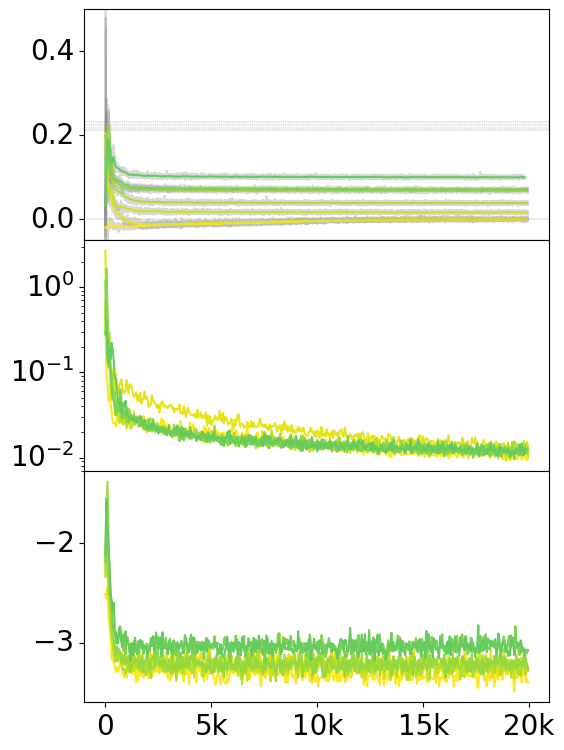

In [ ]:
# 设置全局字体
# plt.rc('font',family='Times New Roman')
# 设置斜体
# plt.rcParams['font.style'] = 'italic'
# 设置公式字体
plt.rcParams['mathtext.fontset'] = 'stix'
# 设置字体大小
plt.rcParams['font.size'] = 20
# 设置背景颜色
plt.rcParams['figure.facecolor'] = 'white'
# 设置背景网格
plt.rcParams['axes.grid'] = False
# 设置ylabel对齐方式为左对齐
plt.rcParams['ytick.alignment'] = 'center'
# 设置默认颜色
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.get_cmap('viridis_r').colors[::10])

# 设置图片大小
plt.figure(figsize=(6, 9))
# 设置colormap
cmap = mpl.cm.get_cmap('Set3')

plt.subplot(311)
plt.plot(Es.loc[::1].rolling(window=1, center=True, min_periods=1).mean(), alpha=0.3, color='gray')
plt.plot(Es1.loc[::50], alpha=1)
plt.ylim(-0.05,0.5)
# plt.ylabel('$Energy (Ha)$')
# 取消横坐标
plt.xticks([])
# plt.xlabel('Epochs')
# plt.xscale("log")
# plt.ylim(-2.05,-1.8)
#在左上角添加(a),(b)..
# plt.text(-0.1, 1.1, '({})'.format(chr(97+0)), transform=plt.gca().transAxes,
#         fontsize='large', fontweight='bold', va='top', ha='right')
# baselines=[]
for baseline in baselines:
    # 设置灰色虚线,线宽设置为0.1
    plt.axhline(y=baseline, color='gray', linestyle='--', linewidth=0.3)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.get_cmap('viridis_r').colors[::10])
plt.subplot(312)
plt.plot(E_vars.loc[::50].rolling(window=1, center=True, min_periods=1).mean(), alpha=1)
plt.yscale("log")
plt.xticks([])
# plt.xlabel('Epochs')
# plt.ylabel('$\Delta E (Ha)$')
# plt.text(-0.1, 1.1, '({})'.format(chr(97+1)), transform=plt.gca().transAxes,
#         fontsize='large', fontweight='bold', va='top', ha='right')
# plt.axhline(y=0.001, color='gray', linestyle='--')

plt.subplot(313)
# 按对数显示
plt.plot(Verlis.loc[::50].rolling(window=1, center=True, min_periods=1).mean(), alpha=1)
# plt.xlabel('$Epochs$')
# plt.ylabel('$V/T$')
plt.xticks([0,5000,10000,15000,20000],['0','5k','10k','15k','20k'])
# plt.xscale("log")
# plt.ylim(-2.2,-1.8)
# plt.text(-0.1, 1.1, '({})'.format(chr(97+3)), transform=plt.gca().transAxes,
#         fontsize='large', fontweight='bold', va='top', ha='right')
# 保存图片
plt.savefig(picture_name+'_cerve.png', dpi=600, bbox_inches='tight')
# plt.show()
# 设置子图间距
plt.subplots_adjust(wspace=0.3, hspace=0)

# 体现重叠矩阵的优化过程

/tmp/ipykernel_1761310/3112690601.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Blues')


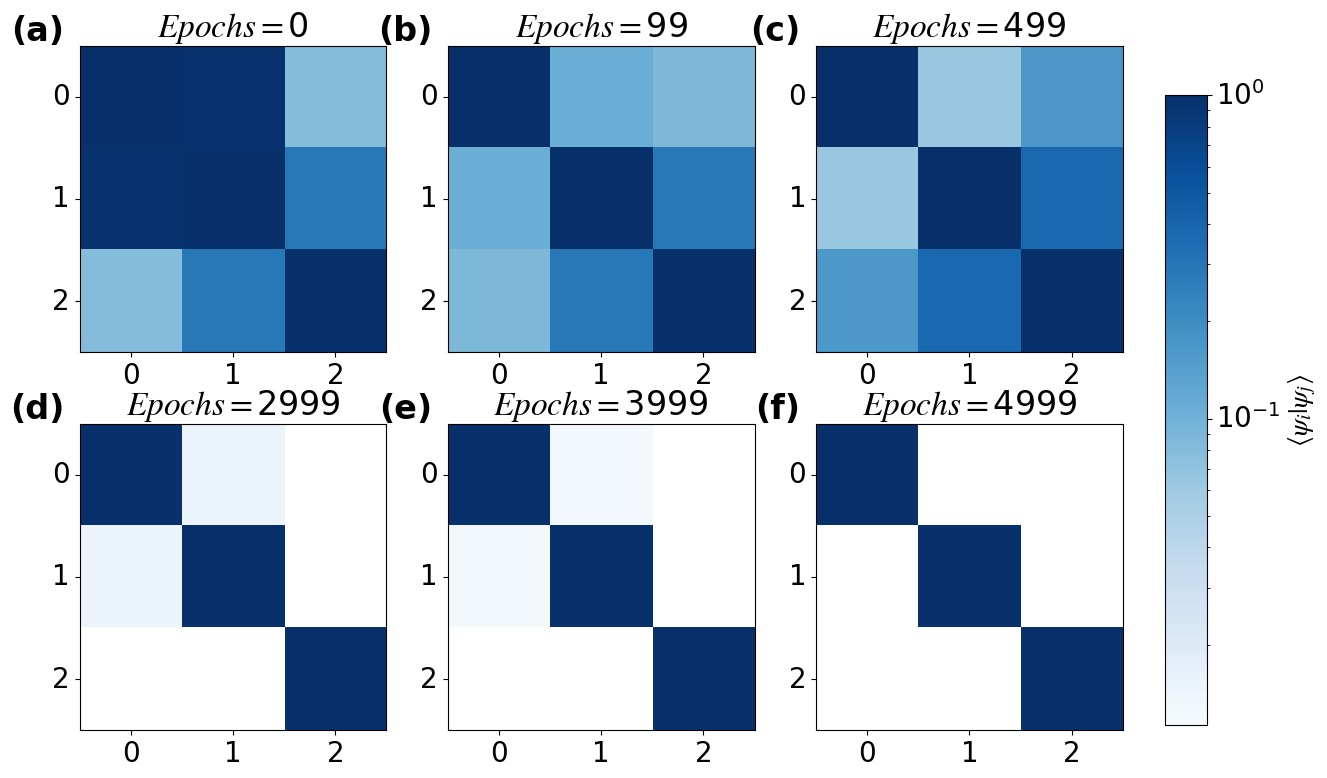

In [107]:
Ss = []
Si = [0,99,499,2999,3999,4999]
S_matrix = np.zeros((len(S),len(S),20000))
# for k in range(6):
# S_matrix = np.zeros((len(S),len(S)))
for i in range(1, len(S)):
    s = S[i].rolling(window=100, center=True, min_periods=1).mean()
    for j in range(i):
        S_matrix[i,j,0:s.shape[0]] = s[s.columns[j-1]]
    # Ss.append(S_matrix.T+S_matrix+np.tile(np.eye(len(S)))
Ss = S_matrix.swapaxes(0,1) + S_matrix+np.tile(np.eye(len(S))[..., None], 20000)

plt.figure(figsize=(14, 9))
# 循环画出Ss
cmap = mpl.cm.get_cmap('Blues')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(Ss[:,:,Si[i]], norm=mpl.colors.LogNorm(vmin=Ss[Ss!=0].min(), vmax=Ss.max()), cmap=cmap, alpha=1)
    plt.title('$Epochs = $'+str(Si[i]))
    #在左上角添加(a),(b)..
    plt.text(-0.05, 1.1, '({})'.format(chr(97+i)), transform=plt.gca().transAxes,
            fontsize='large', fontweight='bold', va='top', ha='right')
# 共享colorbar
plt.subplots_adjust(right=0.87)
cax = plt.axes([0.9, 0.12, 0.03, 0.7])
cb = plt.colorbar(cax=cax)
cb.set_label(r'$\langle\psi_i|\psi_j\rangle$')
# 保存图片
plt.savefig(picture_name+'_overlap.png', dpi=600, bbox_inches='tight')
plt.show()

0.04693802924516539
1.4638178699699165


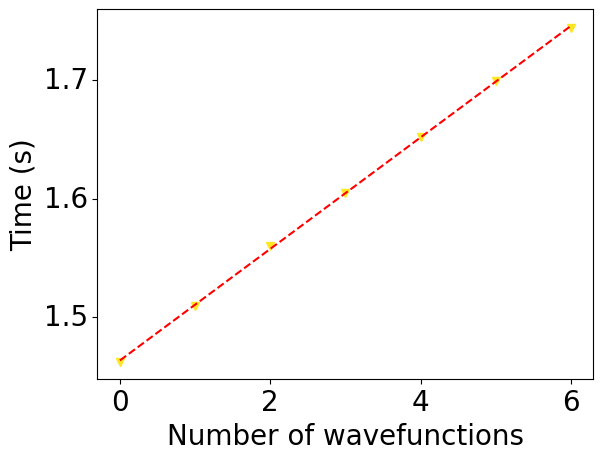

In [ ]:
import numpy as np

y = T.loc[1:].mean()
x = np.linspace(0,len(y)-1,len(y))
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x,y,'v')
plt.plot(x, slope*x+intercept, 'r--')
plt.xlabel('Number of wavefunctions')
plt.ylabel('Time (s)')

print(slope)
print(intercept)


In [ ]:
def findSubsetsWithSum(nums, target):
    def backtrack(start, current_subset, current_sum):
        if current_sum == target:
            subsets.append(current_subset[:])
            return
        for i in range(start, len(nums)):
            if current_sum + nums[i] <= target:
                current_subset.append(nums[i])
                current_sum += nums[i]
                backtrack(i+1, current_subset, current_sum)
                current_sum -= current_subset.pop()

    subsets = []
    backtrack(0, [], 0)
    return subsets

# 示例用法
# nums = np.linspace(1, 10, 10).tolist()
nums = [1,2,3,4,2,5,6,7,8,9,10]
target = 9
nums_t = []
for i in range(len(nums)):
    nums_t += [nums[i]]*(target//nums[i])
# nums = [[nums[i]]*(target//nums[i]) for i in range(len(nums))]
result = findSubsetsWithSum(nums, target)
print(result)

[[1, 2, 4, 2], [1, 2, 6], [1, 3, 5], [1, 2, 6], [1, 8], [2, 3, 4], [2, 2, 5], [2, 7], [3, 4, 2], [3, 6], [4, 5], [2, 7], [9]]


# 波函数节面分析
## full 11D node绘制
### 
## 固定电子节面绘制
### 固定全部电子位点，选择其中一个电子坐标进行网格化计算
### 可视化该网格下波函数

# 波函数轨道可视化